# 用PaddlePaddle复现Fourier Neural Operator



## 训练流程（当前仍有bug）

下面的代码定义了一个简单的训练流程。使用官方代码给出的Darcy flow 数据集，我们尝试训练一个FNO模型。训练过程中，我们使用了Adam优化器优化全体模型参数，我们会发现模型基本会收敛在一个loss还比较高的时候，复原的效果也不如预期。

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape [1, 1, 1], eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32
Training on regular inputs (no multi-grid patching).
Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
[0] time=0.70, avg_loss=43.3557, train_err=0.8671, 16_h1=0.9306, 16_l2=0.7535, 32_h1=1.0043, 32_l2=0.7645
[3] time=0.56, avg_loss=44.7654, train_err=0.8953, 16_h1=0.8797, 16_l2=0.6910, 32_h1=0.9400, 32_l2=0.6854
[6] time=0.54, avg_loss=43.0689, train_err=0.8614, 16_h1=0.8400, 16_l2=0.6523, 32_h1=0.8938, 32_l2=0.6434
[9] time=0.54, avg_loss=40.5029, train_err=0.8101, 16_h1=0.8068, 16_l2=0.6239, 32_h1=0.8893, 32_l2=0.6130
[12] time=0.54, avg_loss=40.8909, train_err=0.8178, 16_h1=0.8294, 16_l2=0.6325, 32_h1=0.9103, 32_l2=0.6231
[15] time=0.60, avg_loss=40.4755, train_err=0.8095, 16_h1=0.8061, 16_l2=0.6107, 32_h1=0.8645, 32_l2=0.6016
[18] time=0.59,

C:\Users\kinet\AppData\Local\Temp\ipykernel_35380\2095561034.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


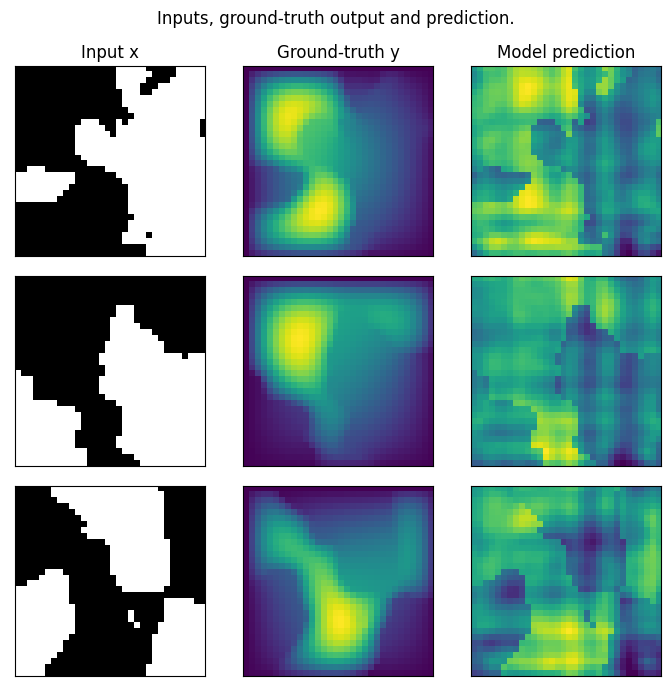

In [9]:
from neuralop.datasets.darcy import load_darcy_flow_small
import paddle
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000, batch_size=32,
    test_resolutions=[16, 32], n_tests=[100, 50], test_batch_sizes=[32, 32],
)

train_dataset = train_loader.dataset


model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64)


optimizer = paddle.optimizer.Adam(learning_rate=1e-3 , parameters=model.parameters())
# cosine annealing scheduler
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=1e-3, T_max=1000)

loss = LpLoss(d=2, p=2)
h1_loss = H1Loss(d=2)

train_loss = h1_loss
eval_losses = {"h1": h1_loss, "l2": loss}

trainer = Trainer(model, n_epochs=20,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  verbose=True)


trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).cuda()).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

## 当前的bug的定位

目前我们认为上述训练流程的错误基本上集中在`FactorizedSpectralConv`中。我们认为这个层的实现有问题，但是我们目前还没有找到问题的根源。我们希望能够得到一些帮助。

### 1. 加载Pytorch中训练的权重

如果我们直接加载PyTorch中训练出来的权重，那么模型的前向推理的精度是足够的。如下所示：


C:\Users\kinet\AppData\Local\Temp\ipykernel_35380\474182347.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


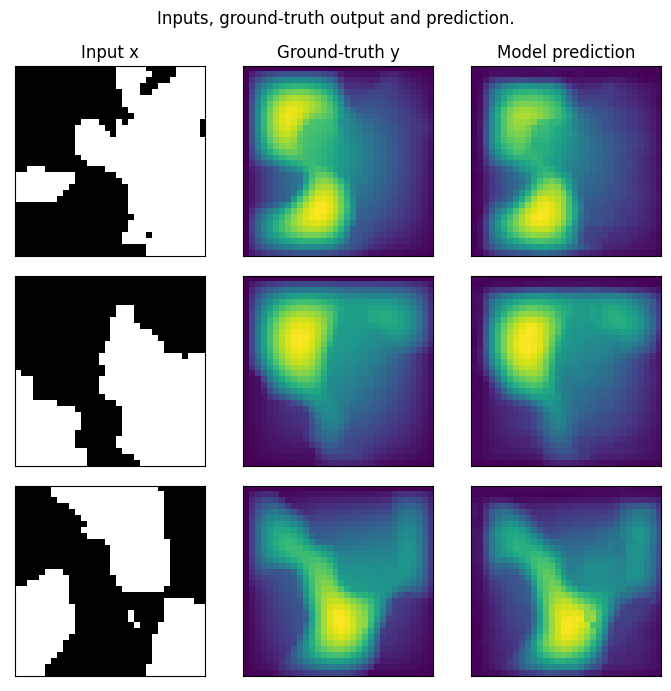

In [10]:
model.load_dict(paddle.load('model_trained.pdparams'))

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).cuda()).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

### 2. 加载后训练FFT之后的层

我们发现，如果我们只训练FFT层后面的参数，那么模型的训练效果会正常。这个现象表明，这一层的梯度计算是有问题的。首先模型的结构如下：

In [11]:
print(model)

TFNO(
  (convs): FactorizedSpectralConv(
    (weight): LayerList(
      (0): FactorizedTensor(shape=(32, 32, 8, 8))
      (1): FactorizedTensor(shape=(32, 32, 8, 8))
      (2): FactorizedTensor(shape=(32, 32, 8, 8))
      (3): FactorizedTensor(shape=(32, 32, 8, 8))
      (4): FactorizedTensor(shape=(32, 32, 8, 8))
      (5): FactorizedTensor(shape=(32, 32, 8, 8))
      (6): FactorizedTensor(shape=(32, 32, 8, 8))
      (7): FactorizedTensor(shape=(32, 32, 8, 8))
    )
  )
  (fno_skips): LayerList(
    (0): SoftGating()
    (1): SoftGating()
    (2): SoftGating()
    (3): SoftGating()
  )
  (lifting): Lifting(
    (fc): Conv2D(3, 32, kernel_size=[1, 1], data_format=NCHW)
  )
  (projection): Projection(
    (fc1): Conv2D(32, 64, kernel_size=[1, 1], data_format=NCHW)
    (fc2): Conv2D(64, 1, kernel_size=[1, 1], data_format=NCHW)
  )
)


在实际的`model.forward(x)`中，层的运算是这样的：

- lifting
- convs (FFT) + fno\_skips
- projection

所以我们只训练projection，可以看到loss是可以正常下降的。

In [12]:
# 注意这里只展开了部分参数到optimizer中
optimizer = paddle.optimizer.Adam(learning_rate=1e-4 , parameters=model.projection.parameters())

trainer = Trainer(model, n_epochs=20,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  verbose=True)

trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on regular inputs (no multi-grid patching).
Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
[0] time=0.58, avg_loss=2.7164, train_err=0.0543, 16_h1=0.1428, 16_l2=0.0926, 32_h1=0.2578, 32_l2=0.1364
[3] time=0.52, avg_loss=2.6919, train_err=0.0538, 16_h1=0.1429, 16_l2=0.0926, 32_h1=0.2581, 32_l2=0.1364
[6] time=0.52, avg_loss=2.6873, train_err=0.0537, 16_h1=0.1429, 16_l2=0.0926, 32_h1=0.2582, 32_l2=0.1362
[9] time=0.54, avg_loss=2.6850, train_err=0.0537, 16_h1=0.1428, 16_l2=0.0926, 32_h1=0.2584, 32_l2=0.1368
[12] time=0.57, avg_loss=2.6837, train_err=0.0537, 16_h1=0.1429, 16_l2=0.0926, 32_h1=0.2584, 32_l2=0.1366
[15] time=0.55, avg_loss=2.6823, train_err=0.0536, 16_h1=0.1429, 16_l2=0.0926, 32_h1=0.2585, 32_l2=0.1366
[18] time=0.57, avg_loss=2.6801, train_err=0.0536, 16_h1=0.1429, 16_l2=0.0926, 32_h1=0.2586, 32_l2=0.1365


C:\Users\kinet\AppData\Local\Temp\ipykernel_35380\474182347.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


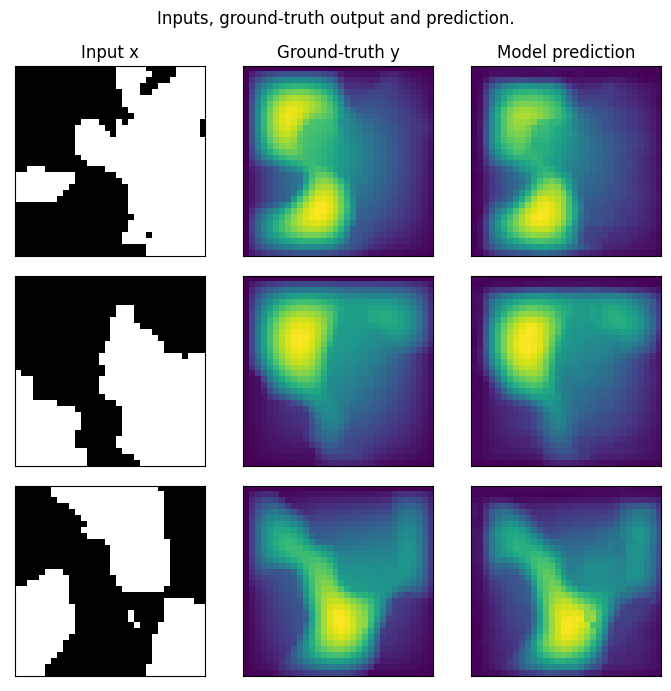

In [13]:
model.load_dict(paddle.load('model_trained.pdparams'))

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).cuda()).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

## 猜测：

当前的精度对齐不足可能还是由于`FactorizedSpectralConv`中使用的fft相关函数导致的梯度出错有关。